In [237]:
# general imports
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from braket.circuits import Circuit, circuit, Instruction
from braket.devices import LocalSimulator

from braket.tracking import Tracker

from scipy.special import iv
from scipy.linalg import expm, block_diag

In [230]:
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator

In [7]:
tracker = Tracker().start()
device = LocalSimulator()

In [8]:
N_sites = 4

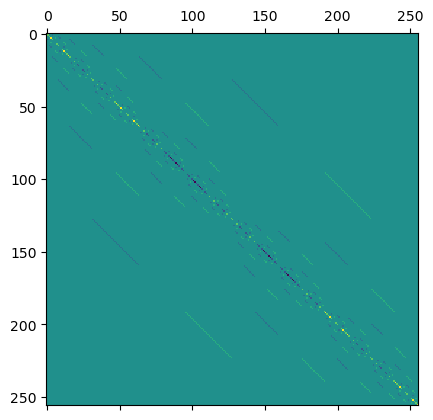

In [233]:
hubbard = fermi_hubbard(1, 4, 1, 4, periodic=False,particle_hole_symmetry=True)
jw_hamiltonian = jordan_wigner(hubbard)
jw_hamiltonian = jordan_wigner(hubbard)
fh_matrix = get_sparse_operator(jw_hamiltonian)
fh_matrix = fh_matrix.todense()
fh_matrix = fh_matrix.real

plt.matshow(fh_matrix)

In [239]:
A = Circuit().unitary(matrix=expm(1j*fh_matrix),targets=range(8))
print(A)

T  : |0|
        
q0 : -U-
      | 
q1 : -U-
      | 
q2 : -U-
      | 
q3 : -U-
      | 
q4 : -U-
      | 
q5 : -U-
      | 
q6 : -U-
      | 
q7 : -U-

T  : |0|


In [3]:
## Get Fermi-Hubbard Hamiltonian

def get_fh_Hamiltonian(t, U, N_sites):
    
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0,-1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    
    dim = 2**(2*N_sites)
    H = np.zeros((dim, dim))
    
    
    return None

In [217]:
## Get Trotterization Hamiltonian Evolution Gate:

def fh_evolution(N_sites, t, U, tau, j, step):
    
    qc = Circuit()
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step
        
        for i in range(N_sites//2):
            qc.xx(2*i,2*i+1,theta)
            qc.yy(2*i,2*i+1,theta)

            qc.xx(2*i+N_sites,2*i+1+N_sites,theta)
            qc.yy(2*i+N_sites,2*i+1+N_sites,theta)
            
        for i in range((N_sites-1)//2):
            qc.xx(2*i+1,2*i+2,theta)
            qc.yy(2*i+1,2*i+2,theta)

            qc.xx(2*i+N_sites+1,2*i+2+N_sites,theta)
            qc.yy(2*i+N_sites+1,2*i+2+N_sites,theta)
        
        ## Potential
        gamma = tau*j*U/(2*step)
        
        for i in range(N_sites):
            qc.zz(i,i+N_sites,gamma)
    return qc

In [218]:
print(fh_evolution(4, 1, 2, 0.5, 1, 1))

T  : |   0    |   1    |            2             |   3    |        4        |
                                                                              
q0 : -XX(0.50)-YY(0.50)----------ZZ(0.50)-------------------------------------
      |        |                 |                                            
q1 : -XX(0.50)-YY(0.50)-XX(0.50)-|-----------------YY(0.50)-ZZ(0.50)----------
                        |        |                 |        |                 
q2 : -XX(0.50)-YY(0.50)-XX(0.50)-|-----------------YY(0.50)-|--------ZZ(0.50)-
      |        |                 |                          |        |        
q3 : -XX(0.50)-YY(0.50)----------|--------ZZ(0.50)----------|--------|--------
                                 |        |                 |        |        
q4 : -XX(0.50)-YY(0.50)----------ZZ(0.50)-|-----------------|--------|--------
      |        |                          |                 |        |        
q5 : -XX(0.50)-YY(0.50)-XX(0.50)----------|--------Y

In [48]:
def czz_gate(angle):
    qc = Circuit()
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    
    return qc

def cxx_gate(angle):
    qc = Circuit()
    qc.h([1,2])
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.h([1,2])
    return qc

def cyy_gate(angle):
    qc = Circuit()
    qc.rx([1,2],pi/2)
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.rx([1,2],-pi/2)
    
    return qc

In [240]:
print(czz_gate(.1))

T  : |0|     1     |2|
                      
q0 : ---C-------------
        |             
q1 : -C-|-----------C-
      | |           | 
q2 : -X-PHASE(0.10)-X-

T  : |0|     1     |2|


In [221]:
## Get circuit for Hadamard Test

def get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real'):
    
    num_qubits = 2*N_sites+1
    qc = Circuit()
    
    qc.h(num_qubits-1)
    
    ## State Initialization
    for i in range(N_sites):
        if i%2!=0:
            qc.x(i)
        else:
            qc.x(i+N_sites)
            
    ## Control-Evolution Gate
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step    
        for i in range(N_sites//2):
            #qc.cxx(num_qubits-1,[2*i,2*i+1],theta)
            qc.add_circuit(cxx_gate(theta),[num_qubits-1, 2*i, 2*i+1])
            
            #qc.cyy(num_qubits-1,[2*i,2*i+1],theta)
            qc.add_circuit(cyy_gate(theta),[num_qubits-1, 2*i, 2*i+1])
            
            #qc.cxx(num_qubits-1,2*i+N_sites,2*i+1+N_sites,theta)
            qc.add_circuit(cxx_gate(theta),[num_qubits-1, 2*i+N_sites, 2*i+1+N_sites])
            
            #qc.cyy(num_qubits-1,2*i+N_sites,2*i+1+N_sites,theta)
            qc.add_circuit(cyy_gate(theta),[num_qubits-1, 2*i+N_sites, 2*i+1+N_sites])

            
            
        for i in range((N_sites-1)//2):
            #qc.cxx(num_qubits-1,[2*i+1,2*i+2],theta)
            qc.add_circuit(cxx_gate(theta),[num_qubits-1, 2*i+1, 2*i+2])
            
            #qc.cyy(num_qubits-1,[2*i+1,2*i+2],theta)
            qc.add_circuit(cyy_gate(theta),[num_qubits-1, 2*i+1, 2*i+2])
            
            qc.add_circuit(cxx_gate(theta),[num_qubits-1, 2*i+1+N_sites, 2*i+2+N_sites])
            qc.add_circuit(cyy_gate(theta),[num_qubits-1, 2*i+1+N_sites, 2*i+2+N_sites])
        
        ## Potential terms
        gamma = tau*U*j/(2*step)
        for i in range(N_sites):
            qc.add_circuit(czz_gate(gamma),[num_qubits-1, i, i+N_sites])
    
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.si(num_qubits-1)
    
    qc.h(num_qubits-1)
    
    qc.probability(target=num_qubits-1)
    return qc


In [222]:
print(get_Hadamard_circuit(N_sites=4, t=1, U=4, tau=.1, j=1, step=1))

T  : |0|1|2|     3     |4|5|   6    |7|     8     |     9     |   10    |11|   12   |13|    14     |     15      |   16    |17 |   18   |19|    20     |    21     |   22    |23|   24   |25|    26     |     27      |   28    |29 |   30   |31|    32     |    33     |   34    |35|   36   |37|    38     |     39      |   40    |41 |    42     |    43     |    44     |45|Result Types|
                                                                                                                                                                                                                                                                                                                                                                                              
q0 : -H---C-------------C-H-Rx(1.57)-C-------------C-----------Rx(-1.57)------------------------------------------------------C-----------------------------------------------------------------------------------------------------------

In [90]:
circ = get_Hadamard_circuit(4, 1, 2, .5, 1, 1, test_type='real')
job = device.run(circ, shots=1000)
res = job.result()
prob = res.values[0]

In [91]:
B = device.run(A, shots=1000)

In [186]:
res = B.result()


[array([0.575, 0.425])]

In [184]:
res.measurements

array([[0, 0, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 0]])

In [143]:
def get_F(beta, j):
    
    F = -1j*np.sqrt(beta/(2*pi))*np.exp(-beta)*(iv(j,beta)+iv(j+1,beta))/(2*j+1)
    #print(np.sqrt(beta/(2*pi)))
    #print((iv(j,beta)+iv(j+1,beta))/(2*j+1))
    return F

In [139]:
def get_F_coefs(d, beta):
    F_list = np.zeros(d+1,dtype='complex128')
    
    for j in range(d):
        F_list[j] = get_F(beta, j)
    
    F_list[d] = -1j*np.sqrt(.5*beta/pi) * np.exp(-beta) * iv(d,beta)/(2*d+1)
    
    return F_list

In [176]:
def get_approx_step_function(d, beta):

    x_list = np.linspace(-pi,pi,10000)
    F_coefs = get_F_coefs(d, beta)

    F_approx = 0.5*np.ones(len(x_list))

    for j, F in enumerate(F_coefs):
        term = 2j*np.sin((2*j+1)*x_list)
        F_approx = F_approx + F*term
    
    return F_approx.real


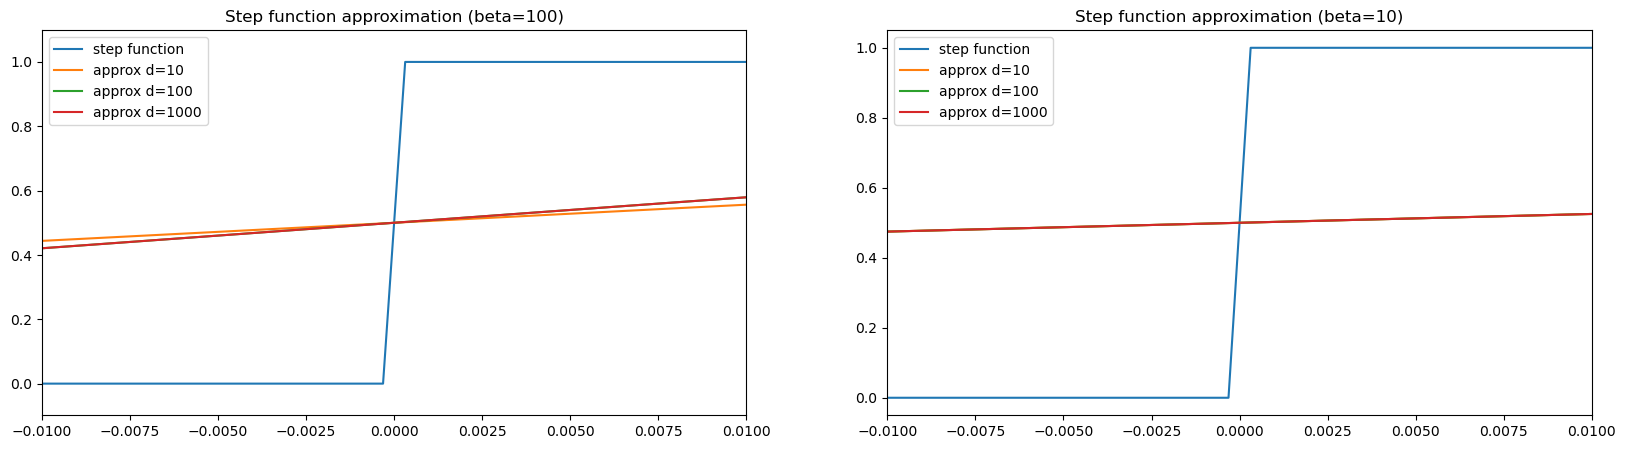

In [241]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(x_list,list(np.zeros(len(x_list)//2))+list(np.ones(len(x_list)//2)),label='step function')
ax[0].plot(x_list,get_approx_step_function(d=10,beta=100),label='approx d=10')
ax[0].plot(x_list,get_approx_step_function(d=100,beta=100),label='approx d=100')
ax[0].plot(x_list,get_approx_step_function(d=1000,beta=100),label='approx d=1000')
ax[0].set_title('Step function approximation (beta=100)')
ax[0].legend()
ax[0].set_xlim([-.01,.01])

ax[1].plot(x_list,list(np.zeros(len(x_list)//2))+list(np.ones(len(x_list)//2)),label='step function')
ax[1].plot(x_list,get_approx_step_function(d=10,beta=10),label='approx d=10')
ax[1].plot(x_list,get_approx_step_function(d=100,beta=10),label='approx d=100')
ax[1].plot(x_list,get_approx_step_function(d=1000,beta=10),label='approx d=1000')
ax[1].set_title('Step function approximation (beta=10)')
ax[1].set_xlim([-.01,.01])
ax[1].legend()

In [191]:
def get_Z(N_sites, t, U, tau, j, step, shots):
    
    qc_real = get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real')
    qc_imag = get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='imag')
    
    device = LocalSimulator()
    job_real = device.run(qc_real, shots=shots)
    job_imag = device.run(qc_imag, shots=shots)
    res_real = job_real.result()
    res_imag = job_imag.result()
    prob_real = res_real.values[0]
    prob_imag = res_imag.values[0]
    
    Z = (prob_real[0]-prob_real[1])+1j*(prob_imag[0]-prob_imag[1])
    
    return Z

In [211]:
def get_Z_list(d, N_sites, t, U, tau, step, shots_per_run): ## shots_per_run should be replaced
    
    Z_list = [get_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_per_run) for j in range(d+1)]
    
    return Z_list

In [223]:
get_Z_list(d=20,N_sites=4, t=1, U=4, tau=0.0185533,step=1, shots_per_run=0)

[(0.9654576180477493+0.25657016821528034j),
 (0.7048637984579385+0.696233541422055j),
 (0.2618628917561368+0.9386340966466541j),
 (-0.2327925386321853+0.9215745936648871j),
 (-0.6379876758009042+0.6620127148783397j),
 (-0.8463475477972526+0.2473936018551347j),
 (-0.8153505111729642-0.19530730107092054j),
 (-0.5757279954986785-0.5413146397440294j),
 (-0.2158300958434316-0.7059544748526572j),
 (0.15098125335514756-0.6664381581667769j),
 (0.4235743634094413-0.46177144202253706j),
 (0.5421329375037663-0.17307608635620264j),
 (0.5004239292741982+0.10690732770824168j),
 (0.3393612368330528+0.30367715347821217j),
 (0.1266344194414502+0.38042147450355235j),
 (-0.06871654496608282+0.3422388808164553j),
 (-0.19751925666494208+0.22627772616550063j),
 (-0.24119677955860097+0.0836037479282925j),
 (-0.21046274568647044-0.039567108222104186j),
 (-0.13490844379630085-0.11486513630810369j),
 (-0.04898826790855504-0.13589747768390348j)]

In [227]:
get_Z(4, 1, 4, .5, 0, 1, 0)

(0.9999999999999958+0j)

\begin{equation}
ACDF(x) = 0.5+\sum^d_{j=0} F_j e^{i(2j+1)x} Z_j
\end{equation}


In [224]:
def Assembly_ACDF(Z_list, F_list, precision):
    
    ACDF = .5*np.ones(precision)
    x_list = np.linspace(-pi,pi,precision)
    d = len(F_list)-1
    
    for j in range(d+1):
        ACDF = ACDF + F_list[j]*Z_list[j]*np.exp(1j*(2*j+1)*x_list)
    
    return ACDF

In [225]:
Z_list = get_Z_list(50, 4, 1, 4, .1, 1, 0)
F_list = get_F_coefs(d=50, beta=10)
ACDF = Assembly_ACDF(Z_list, F_list, 10000)

/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


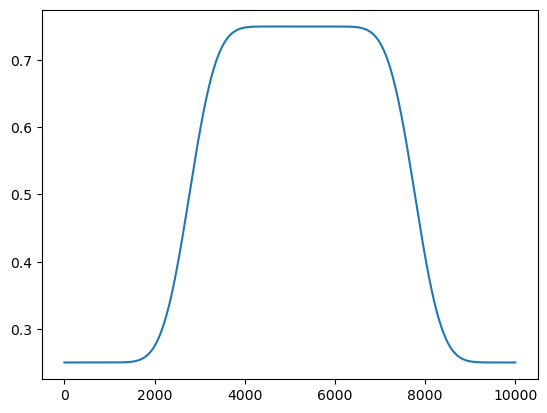

In [226]:
plt.plot(ACDF)

In [210]:
Z_list

[(0.9999999999999958+0j),
 (0.168249345854326-0.5687694384517226j),
 (-0.0715066231190622-0.04636209333428043j),
 (-1.902070972403802e-05+1.6281602004397655e-05j),
 (0.012238660709607774+0.02737985374915264j),
 (0.4083231750021493-0.054521926461663095j),
 (0.14816883521372426-0.94907046256521j),
 (-0.694978417014831-0.32929100435195957j),
 (-0.12174457316904619+0.13601485490341503j),
 (0.0010372259870545242+0.0016800729208182874j),
 (0.006247665978555472-0.0016987442031260458j),
 (0.00558076058392637-0.25215599607111966j),
 (-0.8095027986673714-0.2590735908893518j),
 (-0.511601445760002+0.7520736979429934j),
 (0.20458925667368455+0.24999987133667367j),
 (0.01330776073454476-0.00559858759166143j),
 (-4.947334408400561e-05-0.0004454409191381181j),
 (-0.12929496487754588-0.023127012663110902j),
 (-0.308795709532082+0.616109326946547j),
 (0.7219492617505345+0.6755658063872931j),
 (0.42742884912854395-0.25099216794779267j),
 (-0.012321972421327154-0.049630462253156815j),
 (-3.83267195758207

In [ ]:
Z